# Filter Maximization on VGG16

Name: Anthony Kevin Oktavius

Code Reference:

* https://github.com/anaramirli/visualizing-cnn-features

* https://github.com/fg91/visualizing-cnn-feature-maps/blob/master/filter_visualizer.ipynb

* https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [1]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import imutils
from sklearn.metrics import confusion_matrix, roc_curve

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision import models, transforms
from zipfile import ZipFile
from IPython import display
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
pretrained_model = models.vgg19(
    pretrained = True
).to(device)

pretrained_model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
MAX_LAYERS = 13
pretrained_models_flattened = list(
    pretrained_model.modules()
)[2:MAX_LAYERS]
pretrained_models_flattened

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [5]:
class FilterActivationModel(nn.Module):
  def __init__(self, pretrained_model):
    super(FilterActivationModel, self).__init__()
    self.pretrained_model = nn.Sequential(*pretrained_model)
    self.pretrained_model.eval()

  def forward(self, x):
    x = self.pretrained_model(x)
    return x

filter_activation_model = FilterActivationModel(
    pretrained_models_flattened,
)
filter_activation_model

FilterActivationModel(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [6]:
class BasicHook():
  """
  Get Latest Output from a specific layer.
  """
  def __init__(self, layer_name, layer):
    self.layer_name = layer_name
    self.layer = layer
    self.latest_output = None

    layer.register_forward_hook(self.forward_hook_fn)

  def forward_hook_fn(self, layer, input, output):
    self.latest_output = output

  def close(self):
    self.hook.remove()

In [7]:
print(list(filter_activation_model.modules()))

[FilterActivationModel(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
), Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [8]:
selected_layer_for_filter_maximization = list(
    filter_activation_model.pretrained_model.modules()
)[-1]

selected_layer_name_for_filter_maximization = "VGG16 feature"

hook = BasicHook(
    selected_layer_name_for_filter_maximization,
    selected_layer_for_filter_maximization,
)

print(selected_layer_for_filter_maximization)

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Experiment 1: See individual filters.

============Filter Index [250] (0)==============
Current iteration: 0, with current loss: 1.3091660737991333
Current iteration: 10, with current loss: -36.11122512817383
Current iteration: 20, with current loss: -68.43415069580078
Current iteration: 30, with current loss: -102.85831451416016
Current iteration: 40, with current loss: -139.4314422607422
Current iteration: 50, with current loss: -177.49017333984375
Current iteration: 60, with current loss: -216.75015258789062
Current iteration: 70, with current loss: -256.9518737792969
Current iteration: 80, with current loss: -297.957763671875
Current iteration: 90, with current loss: -339.5345458984375
Current iteration: 0, with current loss: 1.530157446861267
Current iteration: 10, with current loss: -32.6339111328125
Current iteration: 20, with current loss: -64.63858032226562
Current iteration: 30, with current loss: -99.18989562988281
Current iteration: 40, with current loss: -136.45606994628906
Current iteration: 50, with current l

Current iteration: 80, with current loss: -305.35577392578125
Current iteration: 90, with current loss: -349.008056640625
============Filter Index [251] (1)==============
Current iteration: 0, with current loss: 2.835902214050293
Current iteration: 10, with current loss: -16.73946762084961
Current iteration: 20, with current loss: -32.10856246948242
Current iteration: 30, with current loss: -47.8368034362793
Current iteration: 40, with current loss: -64.62152862548828
Current iteration: 50, with current loss: -82.68118286132812
Current iteration: 60, with current loss: -101.79570007324219
Current iteration: 70, with current loss: -121.76708984375
Current iteration: 80, with current loss: -142.51853942871094
Current iteration: 90, with current loss: -163.9133758544922
Current iteration: 0, with current loss: 0.9894718527793884
Current iteration: 10, with current loss: -15.534282684326172
Current iteration: 20, with current loss: -30.11638069152832
Current iteration: 30, with current los

Current iteration: 40, with current loss: -64.43653869628906
Current iteration: 50, with current loss: -83.04890441894531
Current iteration: 60, with current loss: -102.84016418457031
Current iteration: 70, with current loss: -123.54703521728516
Current iteration: 80, with current loss: -144.99249267578125
Current iteration: 90, with current loss: -167.08334350585938
============Filter Index [252] (2)==============
Current iteration: 0, with current loss: 1.11649489402771
Current iteration: 10, with current loss: -34.75973129272461
Current iteration: 20, with current loss: -65.06680297851562
Current iteration: 30, with current loss: -97.91568756103516
Current iteration: 40, with current loss: -134.2760772705078
Current iteration: 50, with current loss: -173.60494995117188
Current iteration: 60, with current loss: -215.62083435058594
Current iteration: 70, with current loss: -259.6382141113281
Current iteration: 80, with current loss: -305.1355895996094
Current iteration: 90, with curre

============Filter Index [253] (3)==============
Current iteration: 0, with current loss: 2.1677656173706055
Current iteration: 10, with current loss: -14.430790901184082
Current iteration: 20, with current loss: -26.09834861755371
Current iteration: 30, with current loss: -37.969688415527344
Current iteration: 40, with current loss: -51.05234909057617
Current iteration: 50, with current loss: -65.07704162597656
Current iteration: 60, with current loss: -79.99952697753906
Current iteration: 70, with current loss: -95.56474304199219
Current iteration: 80, with current loss: -111.6507797241211
Current iteration: 90, with current loss: -128.20614624023438
Current iteration: 0, with current loss: -0.19665661454200745
Current iteration: 10, with current loss: -11.992584228515625
Current iteration: 20, with current loss: -24.067258834838867
Current iteration: 30, with current loss: -36.26892852783203
Current iteration: 40, with current loss: -49.48104476928711
Current iteration: 50, with cur

Current iteration: 60, with current loss: -90.27748107910156
Current iteration: 70, with current loss: -107.8898696899414
Current iteration: 80, with current loss: -126.12144470214844
Current iteration: 90, with current loss: -144.81741333007812
============Filter Index [254] (4)==============
Current iteration: 0, with current loss: -0.5912327766418457
Current iteration: 10, with current loss: -39.45559310913086
Current iteration: 20, with current loss: -71.96407318115234
Current iteration: 30, with current loss: -106.59285736083984
Current iteration: 40, with current loss: -143.56398010253906
Current iteration: 50, with current loss: -182.87193298339844
Current iteration: 60, with current loss: -223.78834533691406
Current iteration: 70, with current loss: -265.7354736328125
Current iteration: 80, with current loss: -308.5829772949219
Current iteration: 90, with current loss: -352.13702392578125
Current iteration: 0, with current loss: 0.0057283006608486176
Current iteration: 10, with

Current iteration: 50, with current loss: -174.57528686523438
Current iteration: 60, with current loss: -214.34210205078125
Current iteration: 70, with current loss: -255.3076171875
Current iteration: 80, with current loss: -297.2767333984375
Current iteration: 90, with current loss: -340.0677490234375


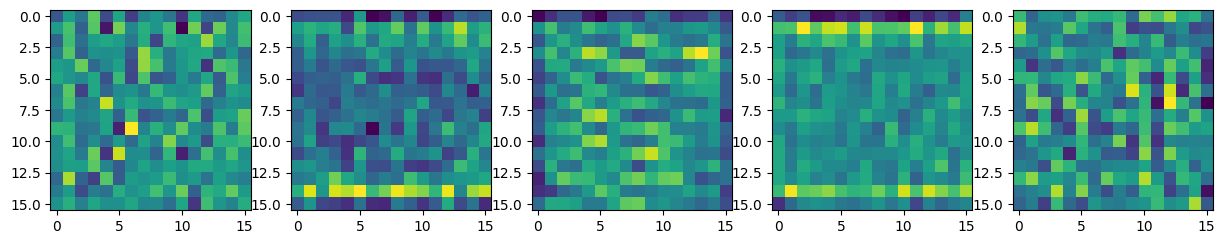

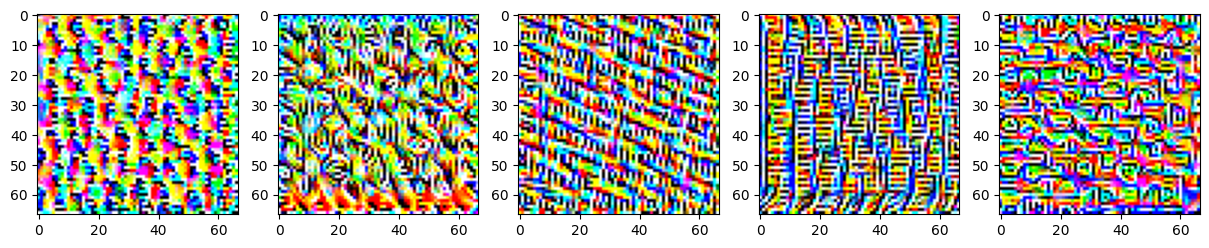

In [9]:
n_iteration = 100
MAX_FILTERS_IN_A_SPECIFIC_LAYER = 255 # Visualize the first 50 filters
START_FILTERS_IN_A_SPECIFIC_LAYER = 250
SELECTED_FILTERS_INDEX = []

for filter_index in range(START_FILTERS_IN_A_SPECIFIC_LAYER, MAX_FILTERS_IN_A_SPECIFIC_LAYER):
  SELECTED_FILTERS_INDEX.append([filter_index])

N_ROWS = 1
N_COLS = 5
UPSCALING_STEPS = 15
UPSCALING_FACTOR = 1.2
FEATURE_SIZE = 56
BLUR_KERNEL_SIZE = 5
fig_filters, axes_filters = plt.subplots(ncols = N_COLS, nrows = N_ROWS, figsize = (15, 15))
fig_filter_maximization, axes_filter_maximization = plt.subplots(ncols = N_COLS, nrows = N_ROWS, figsize = (15, 15))

# norm = transforms.Compose([
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

denorm = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
])

for index, selected_filter_index in enumerate(SELECTED_FILTERS_INDEX):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS
  print(f"============Filter Index {selected_filter_index} ({index})==============")
  sample_input_data_1 = np.random.uniform(100, 200, (FEATURE_SIZE, FEATURE_SIZE, 3)) / 255 # Tensor with uniform distribution.  
  
  for _ in range(UPSCALING_STEPS):
    sample_input_data_1_tensor = torch.Tensor(sample_input_data_1).permute(2, 0, 1)
    sample_input_data_1_tensor = sample_input_data_1_tensor.unsqueeze(0)
    # sample_input_data_1_tensor = norm(sample_input_data_1_tensor)
    sample_input_data_1_tensor.requires_grad = True
    optimizer = optim.Adam([sample_input_data_1_tensor], lr=0.1)
    for iteration in range(n_iteration):
      optimizer.zero_grad()
      output_label = filter_activation_model(sample_input_data_1_tensor.to(device))
      
      specific_layer_output = hook.latest_output
      specific_layer_output = specific_layer_output[:, selected_filter_index, :, :]

      loss = -specific_layer_output.mean()
      loss.backward() # Perform Gradient Ascent.
      optimizer.step()

      if iteration % 10 == 0:
        print(f"Current iteration: {iteration}, with current loss: {loss.item()}")

    new_image_size = int(FEATURE_SIZE * UPSCALING_FACTOR)
    sample_input_data_1 = cv2.resize(sample_input_data_1, (new_image_size, new_image_size), interpolation = cv2.INTER_CUBIC)
    sample_input_data_1 = cv2.blur(sample_input_data_1,(BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE))

  filter_viz_image = hook.latest_output.squeeze(0)[selected_filter_index]
  filter_viz_image = np.transpose(filter_viz_image.cpu().detach().numpy(), (1, 2, 0))
  axes_filters[col_index].imshow(filter_viz_image)

  filter_maximization_viz_image = sample_input_data_1_tensor.squeeze(0)
  filter_maximization_viz_image = denorm(filter_maximization_viz_image)
  filter_maximization_viz_image = np.transpose(filter_maximization_viz_image.cpu().detach().numpy(), (1, 2, 0))
  axes_filter_maximization[col_index].imshow(filter_maximization_viz_image)

## Experiment 2: Combining with several other filters.

============Filter Index [0, 1, 2] (0)==============
Current iteration: 0, with current loss: -2.3432421684265137
Current iteration: 10, with current loss: -15.092535972595215
Current iteration: 20, with current loss: -26.380165100097656
Current iteration: 30, with current loss: -38.375030517578125
Current iteration: 40, with current loss: -51.06028366088867
Current iteration: 0, with current loss: -1.7211041450500488
Current iteration: 10, with current loss: -12.955676078796387
Current iteration: 20, with current loss: -22.873044967651367
Current iteration: 30, with current loss: -33.46604537963867
Current iteration: 40, with current loss: -44.72072219848633
Current iteration: 0, with current loss: -1.4264274835586548
Current iteration: 10, with current loss: -12.753763198852539
Current iteration: 20, with current loss: -22.490821838378906
Current iteration: 30, with current loss: -32.89204025268555
Current iteration: 40, with current loss: -43.95847702026367
Current iteration: 0, wit

Current iteration: 40, with current loss: -46.22638702392578
============Filter Index [1, 2, 3] (1)==============
Current iteration: 0, with current loss: -2.230719804763794
Current iteration: 10, with current loss: -18.111961364746094
Current iteration: 20, with current loss: -32.57114791870117
Current iteration: 30, with current loss: -47.816837310791016
Current iteration: 40, with current loss: -63.710548400878906
Current iteration: 0, with current loss: -1.6479108333587646
Current iteration: 10, with current loss: -15.525071144104004
Current iteration: 20, with current loss: -28.369022369384766
Current iteration: 30, with current loss: -41.82362747192383
Current iteration: 40, with current loss: -56.14509582519531
Current iteration: 0, with current loss: -1.372465968132019
Current iteration: 10, with current loss: -15.188408851623535
Current iteration: 20, with current loss: -28.09251594543457
Current iteration: 30, with current loss: -41.83767318725586
Current iteration: 40, with 

============Filter Index [2, 3, 4] (2)==============
Current iteration: 0, with current loss: -1.907270908355713
Current iteration: 10, with current loss: -21.5037841796875
Current iteration: 20, with current loss: -40.03929138183594
Current iteration: 30, with current loss: -59.39870071411133
Current iteration: 40, with current loss: -79.87032318115234
Current iteration: 0, with current loss: -1.5635106563568115
Current iteration: 10, with current loss: -19.16214370727539
Current iteration: 20, with current loss: -35.88783264160156
Current iteration: 30, with current loss: -53.65133285522461
Current iteration: 40, with current loss: -72.5934829711914
Current iteration: 0, with current loss: -1.2602146863937378
Current iteration: 10, with current loss: -18.8206729888916
Current iteration: 20, with current loss: -35.60213088989258
Current iteration: 30, with current loss: -53.970848083496094
Current iteration: 40, with current loss: -73.59569549560547
Current iteration: 0, with current 

============Filter Index [3, 4, 5] (3)==============
Current iteration: 0, with current loss: -2.107011556625366
Current iteration: 10, with current loss: -25.312402725219727
Current iteration: 20, with current loss: -46.04145050048828
Current iteration: 30, with current loss: -67.97660064697266
Current iteration: 40, with current loss: -91.09506225585938
Current iteration: 0, with current loss: -1.2168129682540894
Current iteration: 10, with current loss: -20.952133178710938
Current iteration: 20, with current loss: -38.8798828125
Current iteration: 30, with current loss: -58.540924072265625
Current iteration: 40, with current loss: -79.74385833740234
Current iteration: 0, with current loss: -0.7331483960151672
Current iteration: 10, with current loss: -21.19349479675293
Current iteration: 20, with current loss: -39.7886962890625
Current iteration: 30, with current loss: -59.89470291137695
Current iteration: 40, with current loss: -81.62212371826172
Current iteration: 0, with current 

============Filter Index [4, 5, 6] (4)==============
Current iteration: 0, with current loss: -1.7218217849731445
Current iteration: 10, with current loss: -22.137083053588867
Current iteration: 20, with current loss: -39.19831085205078
Current iteration: 30, with current loss: -57.41949462890625
Current iteration: 40, with current loss: -76.77445220947266
Current iteration: 0, with current loss: -1.1067404747009277
Current iteration: 10, with current loss: -18.813934326171875
Current iteration: 20, with current loss: -34.192405700683594
Current iteration: 30, with current loss: -50.9459114074707
Current iteration: 40, with current loss: -69.06999969482422
Current iteration: 0, with current loss: -0.8563151955604553
Current iteration: 10, with current loss: -18.3748779296875
Current iteration: 20, with current loss: -33.44630813598633
Current iteration: 30, with current loss: -49.98480224609375
Current iteration: 40, with current loss: -67.95767211914062
Current iteration: 0, with curr

============Filter Index [5, 6, 7] (5)==============
Current iteration: 0, with current loss: -1.4127384424209595
Current iteration: 10, with current loss: -24.7396297454834
Current iteration: 20, with current loss: -43.537532806396484
Current iteration: 30, with current loss: -63.508548736572266
Current iteration: 40, with current loss: -84.87510681152344
Current iteration: 0, with current loss: -0.36905577778816223
Current iteration: 10, with current loss: -20.165273666381836
Current iteration: 20, with current loss: -37.847740173339844
Current iteration: 30, with current loss: -56.90199279785156
Current iteration: 40, with current loss: -77.5785140991211
Current iteration: 0, with current loss: -0.29354092478752136
Current iteration: 10, with current loss: -19.92972755432129
Current iteration: 20, with current loss: -36.762001037597656
Current iteration: 30, with current loss: -55.19230270385742
Current iteration: 40, with current loss: -75.24730682373047
Current iteration: 0, with 

============Filter Index [6, 7, 8] (6)==============
Current iteration: 0, with current loss: -0.5588591694831848
Current iteration: 10, with current loss: -16.17841148376465
Current iteration: 20, with current loss: -28.67481231689453
Current iteration: 30, with current loss: -41.93218231201172
Current iteration: 40, with current loss: -56.20623779296875
Current iteration: 0, with current loss: -0.2098814696073532
Current iteration: 10, with current loss: -13.37256908416748
Current iteration: 20, with current loss: -25.063892364501953
Current iteration: 30, with current loss: -37.718040466308594
Current iteration: 40, with current loss: -51.40312957763672
Current iteration: 0, with current loss: -0.2510194480419159
Current iteration: 10, with current loss: -13.362786293029785
Current iteration: 20, with current loss: -25.210119247436523
Current iteration: 30, with current loss: -37.852577209472656
Current iteration: 40, with current loss: -51.455936431884766
Current iteration: 0, with

============Filter Index [7, 8, 9] (7)==============
Current iteration: 0, with current loss: -1.116396427154541
Current iteration: 10, with current loss: -15.623174667358398
Current iteration: 20, with current loss: -27.50914764404297
Current iteration: 30, with current loss: -40.058387756347656
Current iteration: 40, with current loss: -53.82986831665039
Current iteration: 0, with current loss: -0.6478268504142761
Current iteration: 10, with current loss: -11.649884223937988
Current iteration: 20, with current loss: -22.803661346435547
Current iteration: 30, with current loss: -35.425987243652344
Current iteration: 40, with current loss: -49.05994415283203
Current iteration: 0, with current loss: -0.6848008036613464
Current iteration: 10, with current loss: -11.658047676086426
Current iteration: 20, with current loss: -22.280065536499023
Current iteration: 30, with current loss: -33.96244430541992
Current iteration: 40, with current loss: -46.67424392700195
Current iteration: 0, with

============Filter Index [8, 9, 10] (8)==============
Current iteration: 0, with current loss: -0.9398468136787415
Current iteration: 10, with current loss: -10.04342269897461
Current iteration: 20, with current loss: -18.52703094482422
Current iteration: 30, with current loss: -27.644798278808594
Current iteration: 40, with current loss: -37.42937088012695
Current iteration: 0, with current loss: -0.6717085838317871
Current iteration: 10, with current loss: -8.123743057250977
Current iteration: 20, with current loss: -15.362122535705566
Current iteration: 30, with current loss: -23.19076919555664
Current iteration: 40, with current loss: -31.849252700805664
Current iteration: 0, with current loss: -0.7690300345420837
Current iteration: 10, with current loss: -7.744449138641357
Current iteration: 20, with current loss: -14.845659255981445
Current iteration: 30, with current loss: -22.97018814086914
Current iteration: 40, with current loss: -32.212493896484375
Current iteration: 0, with

============Filter Index [9, 10, 11] (9)==============
Current iteration: 0, with current loss: -1.9393514394760132
Current iteration: 10, with current loss: -14.00052261352539
Current iteration: 20, with current loss: -24.310306549072266
Current iteration: 30, with current loss: -35.191619873046875
Current iteration: 40, with current loss: -46.888919830322266
Current iteration: 0, with current loss: -0.8737820386886597
Current iteration: 10, with current loss: -10.632305145263672
Current iteration: 20, with current loss: -19.527048110961914
Current iteration: 30, with current loss: -29.388559341430664
Current iteration: 40, with current loss: -40.303775787353516
Current iteration: 0, with current loss: -0.8519710898399353
Current iteration: 10, with current loss: -10.512181282043457
Current iteration: 20, with current loss: -19.77983283996582
Current iteration: 30, with current loss: -29.87079620361328
Current iteration: 40, with current loss: -41.0909309387207
Current iteration: 0, w

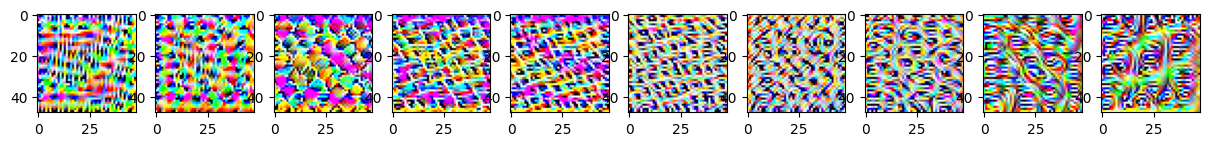

In [11]:
n_iteration = 50
MAX_FILTERS_IN_A_SPECIFIC_LAYER = 10 # Visualize the first 50 filters
SELECTED_FILTERS_INDEX = []

# Visualize the first 10 * 3 filters
for filter_index in range(0, MAX_FILTERS_IN_A_SPECIFIC_LAYER):
  SELECTED_FILTERS_INDEX.append([filter_index, filter_index + 1, filter_index + 2])

N_ROWS = 1
N_COLS = 10
UPSCALING_STEPS = 30
UPSCALING_FACTOR = 1.2
BLUR_KERNEL_SIZE = 5
FEATURE_SIZE = 40

fig_filter_maximization, axes_filter_maximization = plt.subplots(ncols = N_COLS, nrows = N_ROWS, figsize = (15, 15))

norm = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

denorm = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
])

for index, selected_filter_index in enumerate(SELECTED_FILTERS_INDEX):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS
  print(f"============Filter Index {selected_filter_index} ({index})==============")
  sample_input_data_1 = np.random.uniform(100, 200, (FEATURE_SIZE, FEATURE_SIZE, 3)) / 255 # Tensor with uniform distribution.  
  
  for _ in range(UPSCALING_STEPS):
    sample_input_data_1_tensor = torch.Tensor(sample_input_data_1).permute(2, 0, 1)
    sample_input_data_1_tensor = sample_input_data_1_tensor.unsqueeze(0)
    sample_input_data_1_tensor = norm(sample_input_data_1_tensor)
    sample_input_data_1_tensor.requires_grad = True
    optimizer = optim.Adam([sample_input_data_1_tensor], lr=0.1)
    for iteration in range(n_iteration):
      optimizer.zero_grad()
      output_label = pretrained_model(sample_input_data_1_tensor.to(device))
      
      specific_layer_output = hook.latest_output
      specific_layer_output = specific_layer_output[:, selected_filter_index, :, :]

      loss = -specific_layer_output.mean()
      loss.backward() # Perform Gradient Ascent.
      optimizer.step()

      if iteration % 10 == 0:
        print(f"Current iteration: {iteration}, with current loss: {loss.item()}")

    new_image_size = int(FEATURE_SIZE * UPSCALING_FACTOR)
    sample_input_data_1 = cv2.resize(sample_input_data_1, (new_image_size, new_image_size), interpolation = cv2.INTER_CUBIC)
    sample_input_data_1 = cv2.blur(sample_input_data_1,(BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE))
  
  # filter_viz_image = hook.latest_output.squeeze(0)[selected_filter_index]
  # filter_viz_image = np.transpose(filter_viz_image.cpu().detach().numpy(), (1, 2, 0))
  # axes_filters[col_index].imshow(filter_viz_image)

  filter_maximization_viz_image = sample_input_data_1_tensor.squeeze(0)
  filter_maximization_viz_image = denorm(filter_maximization_viz_image)
  filter_maximization_viz_image = np.transpose(filter_maximization_viz_image.cpu().detach().numpy(), (1, 2, 0))
  axes_filter_maximization[col_index].imshow(filter_maximization_viz_image)